# 02 - Modelo Inicial
Repositorio: [github.com/MateoRomano02/tp_equidad](https://github.com/MateoRomano02/tp_equidad)


Este notebook corresponde al punto N°2 y N°3 del TP

## Objetivo
Entrenar un modelo de clasificación sobre el dataset *German Credit Data* y evaluar su rendimiento con métricas como accuracy, precision, recall y F1-score. Además, se analizará cuál error es más costoso para el banco.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Carga de datos

In [99]:

df = pd.read_csv("german_credit_clean.csv")

df.head()


,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account_bonds,employment_since,installment_rate_pct,personal_status_sex,other_debtors_guarantors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,Good
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,Bad
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,Good
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,Good
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,Bad


In [101]:
print(df['personal_status_sex'].unique())


['A93' 'A92' 'A91' 'A94']


In [103]:
df['personal_status_sex'] = df['personal_status_sex'].str.strip()
df['gender'] = np.where(df['personal_status_sex'].isin(['A92', 'A95']), 'female', 'male')


## Modelo

In [545]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
X = df.drop(["target",'personal_status_sex'],axis=1)
y = df["target"]  # 0 = Bad credit, 1 = Good credit
gender = df["gender"]  # codificado (0 = male, 1 = female)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [547]:
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X_scaled, y, gender, test_size=0.3, random_state=42
)


In [549]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [551]:
y_pred = clf.predict(X_test)

df_pred = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred,
    'gender': gender_test.values
})

df_pred['gender'] = df_pred['gender'].map({0: 'male', 1: 'female'})

## MATRIZ DE CONFUSION

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.70      0.44      0.54        91
           1       0.79      0.92      0.85       209

    accuracy                           0.77       300
   macro avg       0.75      0.68      0.70       300
weighted avg       0.76      0.77      0.76       300

Matriz de confusión:


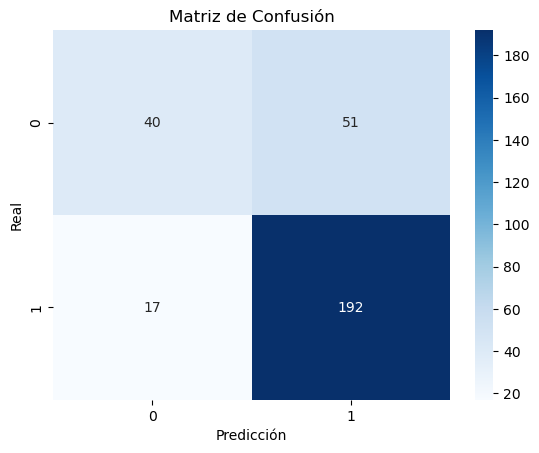

In [554]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


## Análisis de errores y trade-off

En el contexto bancario, donde el objetivo es **maximizar los préstamos otorgados a personas que efectivamente los van a pagar**, el **falso positivo** (darle un préstamo a alguien que no lo va a pagar) puede representar una **pérdida financiera** significativa.

En cambio, un **falso negativo** (negarle un préstamo a alguien que sí lo iba a pagar) implica una oportunidad perdida, pero no un costo directo. Por eso, **los falsos positivos son el error más costoso** en este escenario.

Esto debería reflejarse en el umbral de decisión y posiblemente en la elección de métricas (por ejemplo, priorizar precisión sobre recall).


# 03 - Evaluación de equidad del modelo inicial


## Descripcion de las metricas de fairness vistas en clase para este contexto

1)Statistical Parity:
La proporcion de creditos aprobados de ambos grupos analizados debe ser estar dentro de nuestro criterio de comparacion.
Independientemente de la proporcion de buenos pagadores en ambos grupos, la prediccion positiva deberia ser la misma.

2)Equalized Odds:
La tasa de TPR y FPR debe ser la misma en ambos grupos.Es decir que el modelo se equivoca y acierta en la misma proporcion para ambos grupos, con respecto a la aprobacion
de creditos en ambos grupos.

3)Equal Opportunity:
El modelo se asegura de que en solo el caso de quienes si pagarian el prestamo, sea igual la proporcion de aprobados crediticiamente para los dos grupos.

4)Predictive Parity:
Se busca que la calidad de aprobaciones sea equitativa para ambos grupos.

## Analisis de fairnes en el modelo anterior

El umbral que nosotros proponemos para la diferencia del modulo entre las metricas de ambos grupos es el del 0,10 %

In [563]:
print(df_pred.groupby("gender")["y_true"].value_counts(normalize=True))


gender  y_true
female  1         0.707547
        0         0.292453
male    1         0.670455
        0         0.329545
Name: proportion, dtype: float64


In [565]:
print(df_pred.groupby("gender")["y_pred"].value_counts(normalize=True))


gender  y_pred
female  1         0.825472
        0         0.174528
male    1         0.772727
        0         0.227273
Name: proportion, dtype: float64


In [567]:
pred_male = df_pred[df_pred['gender'] == 'male']
pred_female = df_pred[df_pred['gender'] == 'female']

In [569]:
pred_male

,y_true,y_pred,gender
0,0,1,male
12,1,1,male
17,1,1,male
18,0,1,male
19,1,1,male
...,...,...,...
284,1,1,male
286,0,0,male
294,1,1,male
295,1,1,male


In [571]:
pred_female

,y_true,y_pred,gender
1,1,1,female
2,1,0,female
3,1,1,female
4,1,1,female
5,1,1,female
...,...,...,...
292,1,0,female
293,1,1,female
296,0,1,female
297,1,1,female


## Obtencion de las metricas

In [574]:
def stats_fairness(df):
    y_true=df['y_true']
    y_pred=df["y_pred"]
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn)
    tpr=tp/(tp+fn)
    statistical_parity=(tp+fp)/(tp+fp+tn+fn)
    predictive_parity=tp/(tp+fp)
    

    return statistical_parity,predictive_parity,tpr,fpr



In [576]:
sp_male,pp_male,tpr_male,fpr_male=stats_fairness(pred_male)

In [578]:
sp_female,pp_female,tpr_female,fpr_female=stats_fairness(pred_female)

## Comparacion entre ambos grupos

In [581]:
#Statistical parity
print("Sp del grupo masculino:", sp_male)
print("Sp del grupo femenino:",sp_female)
print("La diferencia modular es:",sp_female-sp_male)

Sp del grupo masculino: 0.7727272727272727
Sp del grupo femenino: 0.8254716981132075
La diferencia modular es: 0.05274442538593482


In [583]:
#Equalized Odds:
print("Tpr del grupo masculino:", tpr_male)
print("Tpr del grupo femenino:",tpr_female)
print("La diferencia modular del tpr es:",tpr_female-tpr_male)


print("Fpr del grupo masculino:", fpr_male)
print("Fpr del grupo femenino:",fpr_female)
print("La diferencia modular del fpr es:",fpr_female-fpr_male)


Tpr del grupo masculino: 0.9152542372881356
Tpr del grupo femenino: 0.92
La diferencia modular del tpr es: 0.004745762711864443
Fpr del grupo masculino: 0.4827586206896552
Fpr del grupo femenino: 0.5967741935483871
La diferencia modular del fpr es: 0.11401557285873193


In [587]:
#Predictive Parity
print("Predictive parity del grupo masculino:", pp_male)
print("predictive parity del grupo femenino:",pp_female)
print("La diferencia modular es:",pp_male-pp_female)

Predictive parity del grupo masculino: 0.7941176470588235
predictive parity del grupo femenino: 0.7885714285714286
La diferencia modular es: 0.005546218487394894


## Conclusiones de los resultados de las metricas

Cumple Statistical Parity, Predictive Parity y Equal Opportunity pero no cumple Equalized Odds

## Eleccion del criterio de fairness

Nosotros elegimos el criterio de equalized odds.

Debido a que como personal del banco tenemos que encontrar un balance que no perjudique a los clientes pero tampoco a nuestra institucion.
Asi que los clientes que si pagaran son aprobados en las mismas probabilidades entre hombres y mujeres.


Mientras que los que no pagarian, son rechazados en la misma probabilidad para los dos grupos.
El aumento del FPR en mujeres podria ser un riesgo para el banco por lo que esta medida, haria el modelo mas confiable desde una perspectiva bancaria.